In [32]:
import lz4.frame
import pickle
import os
import pdb

from utilities.io_tools import input_tools, output_tools
from wremnants import plot_tools, theory_corrections, histselections as sel

In [6]:
webdir = "/home/d/dwalter/www/WMassAnalysis/231221_ewFSR_fiducial/"

t_axis = {
    "ewPTll": r"$p_\mathrm{T}^{\ell\ell}$",
    "ewMll": r"$m^{\ell\ell}$",
    "Mll": r"$m^{\ell\ell}$",
    "Yll": r"$|Y^{\ell\ell}|$",
}
t_label_num = {
    "winhacloew": "winhac FSR", 
    "horaceqedew": "horace FSR", 
    "horacelophotosmecoffew": "photos(MEC off) FSR", 
}
t_label_den = {
    "winhacloew": "photos FSR", 
    "horaceqedew": "photos FSR", 
    "horacelophotosmecoffew": "photos FSR", 
}

translate_txt = {
    "Wplus": r"$W^{+}\rightarrow\mu\nu$",
    "Wminus": r"$W^{-}\rightarrow\mu\nu$",
}

In [7]:
def get_corr(filename):
    with lz4.frame.open(filename) as f:
        corr = pickle.load(f)
        return corr

In [8]:
res, _1, _2 = input_tools.read_infile("/scratch/dwalter/results_histmaker/231221_ewFSR_fiducial/w_z_gen_dists_merged.hdf5")

In [10]:
res["Zmumu_horace-lo-photos-mecoff"]["output"]["nominal_pt"].get()

Hist(Regular(50, 20, 70, name='postfsrLep_pt'), storage=Weight()) # Sum: WeightedSum(value=2.32081e+08, variance=2.32274e+08) (WeightedSum(value=2.84121e+08, variance=2.8436e+08) with flow)

In [18]:
hists = get_corr("../test_231221_ewFSR_fiducial/horaceqedewCorrZ.pkl.lz4")
hists.update(get_corr("../test_231221_ewFSR_fiducial/horaceqedewCorrW.pkl.lz4"))
hists["W"].update(get_corr("../test_231221_ewFSR_fiducial/winhacloewCorrW.pkl.lz4")["W"])

hists["Z"].update(get_corr("../test_231221_ewFSR_fiducial/horacelophotosmecoffewCorrZ.pkl.lz4")["Z"])
hists["W"].update(get_corr("../test_231221_ewFSR_fiducial/horacelophotosmecoffewCorrW.pkl.lz4")["W"])

hists.keys()
hists["W"].keys()

dict_keys(['horaceqedew_minnlo_ratio', 'horaceqedew_num', 'horaceqedew_den', 'winhacloew_minnlo_ratio', 'winhacloew_num', 'winhacloew_den', 'horacelophotosmecoffew_minnlo_ratio', 'horacelophotosmecoffew_num', 'horacelophotosmecoffew_den'])

In [41]:
def plot_corr(process, axis, nums, den, selection=None, xlim=[0,100], rrange=None):
    if type(axis)!=list:
        axis = [axis]
    
    if selection:
        h1ds = [
            hists[process][f"{den}_den"][selection].project(*axis), 
            *[hists[process][f"{n}_num"][selection].project(*axis) for n in nums]]
        rrange = [0.9975, 1.0025] if rrange is None else rrange
        if "charge" in selection:
            process = process.replace("W", "Wminus") if selection["charge"] == 0 else process.replace("W", "Wplus")
    else:
        h1ds = [hists[process][f"{den}_den"].project(*axis), *[hists[process][f"{n}_num"].project(*axis) for n in nums]]
        rrange = [0.996, 1.004] if rrange is None else rrange

    if len(axis)>1:
        h1ds = [sel.unrolledHist(h1d, binwnorm=1, obs=axis) for h1d in h1ds]

    fig = plot_tools.makePlotWithRatioToRef(
                h1ds,
                [t_label_den.get(den,den), *[t_label_num.get(n, n) for n in nums]],
                colors=["black", *["red", "blue"][:len(nums)]], 
                linestyles=["solid", *["dashed", "dotted"][:len(nums)]],
                xlabel=" ".join([t_axis.get(a, a) for a in axis]), 
                ylabel="Events/bin",
                rlabel="x/photos FSR",
                legtext_size=16,
                rrange=rrange,
                yscale=1.0,
                xlim=xlim, binwnorm=1.0, baseline=True, extra_text=translate_txt.get(process, rf"${process}\rightarrow\mu\mu$"))
    
    output_tools.make_plot_dir(webdir, process)
    out = os.path.join(webdir, process)
    plot_tools.save_pdf_and_png(out, f"{den}_{process}_{axis}")
    plot_tools.write_index_and_log(out, f"{den}_{process}_{axis}")

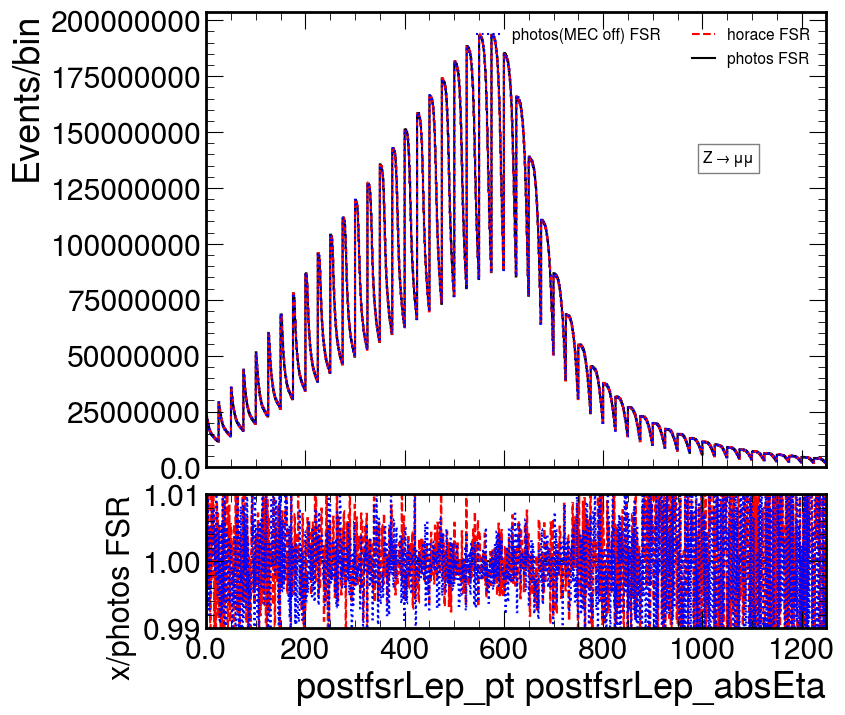

In [44]:
plot_corr("Z", ["postfsrLep_pt","postfsrLep_absEta"], ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", xlim=[0,2.5], rrange=[0.99,1.01])

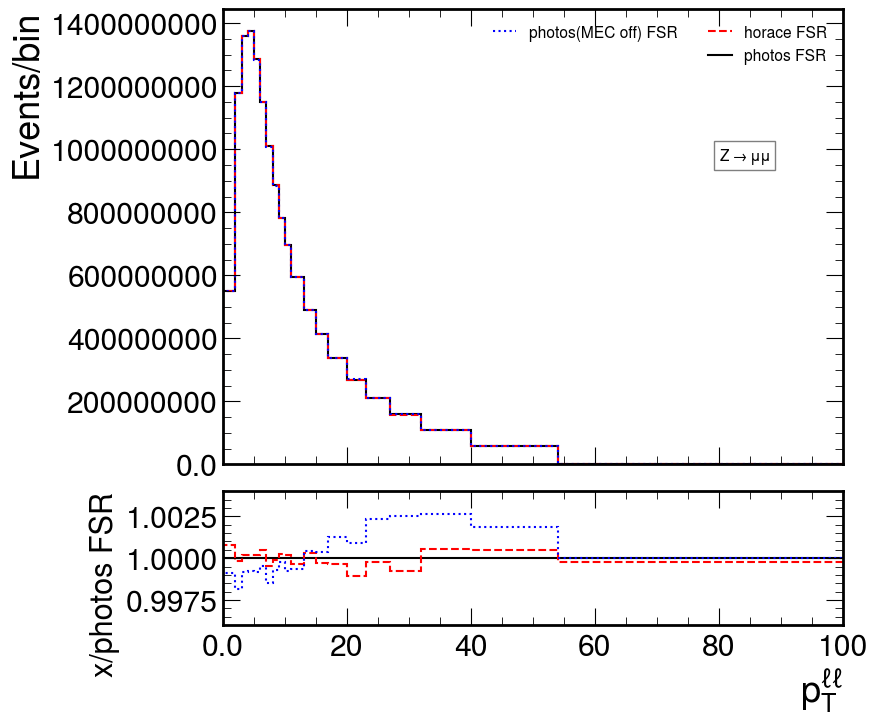

In [157]:
plot_corr("Z", "ewPTll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", xlim=[0,100])

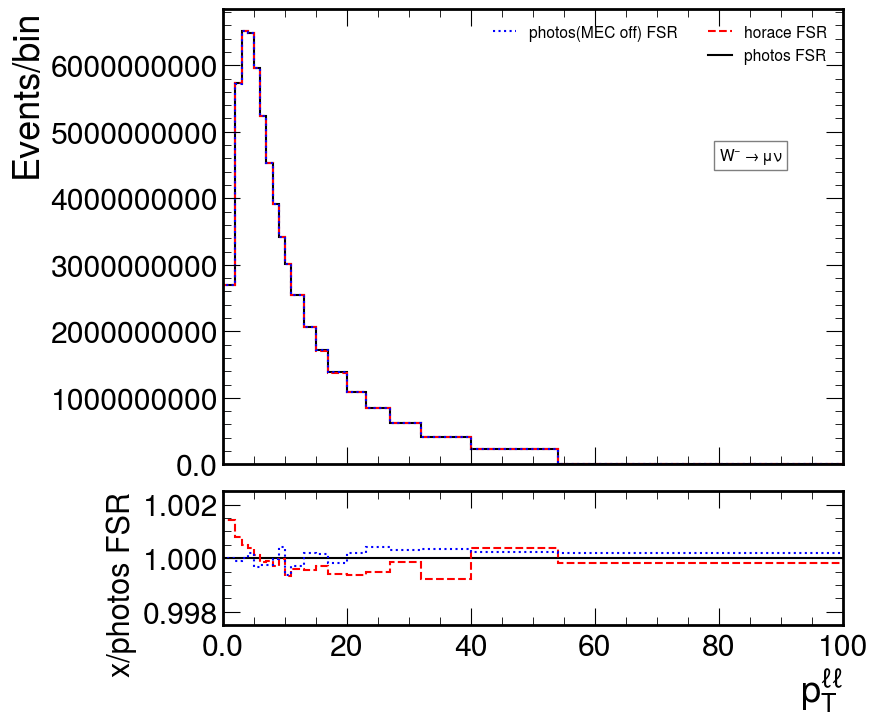

In [158]:
plot_corr("W", "ewPTll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":0}, xlim=[0,100])

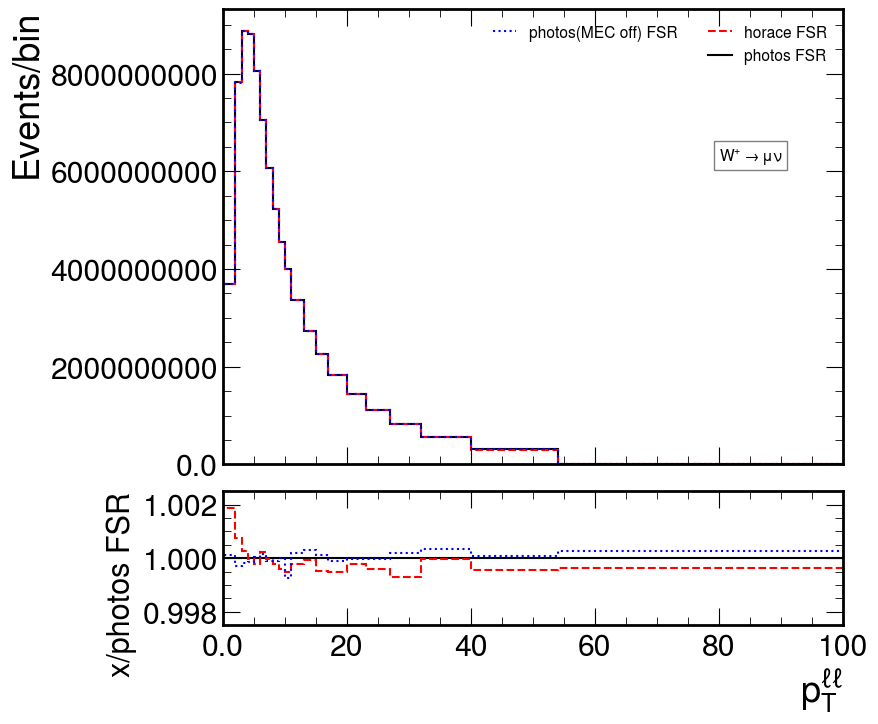

In [159]:
plot_corr("W", "ewPTll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":1}, xlim=[0,100])

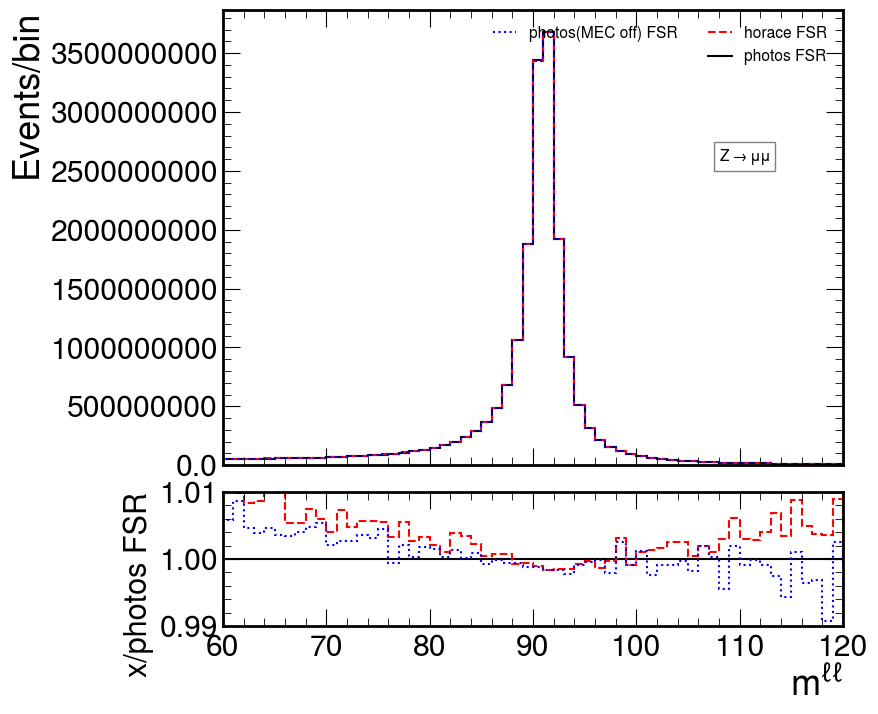

In [171]:
plot_corr("Z", "Mll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", xlim=[60,120], rrange=[0.99, 1.01])

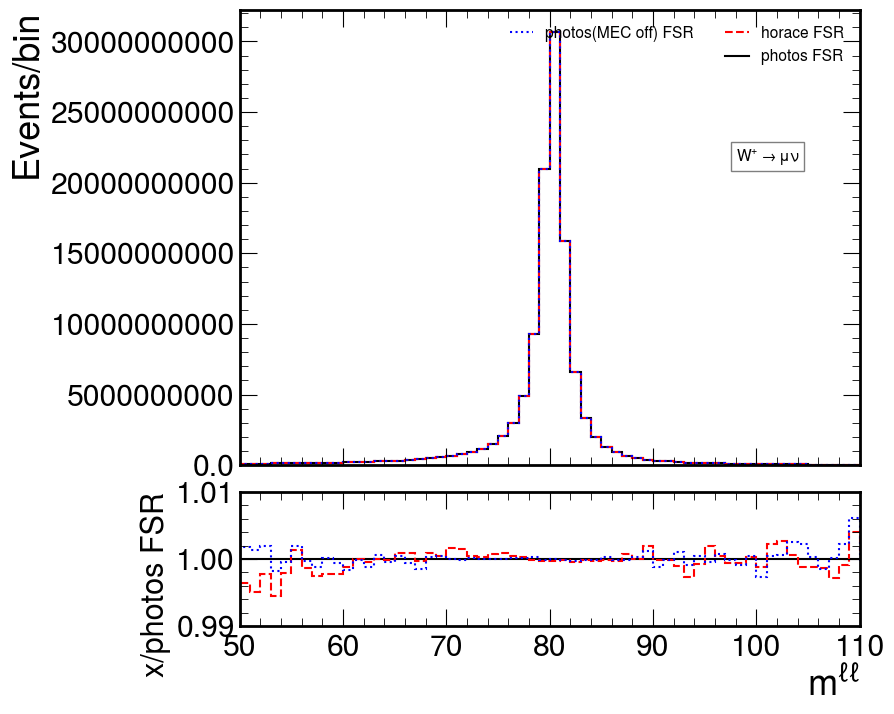

In [173]:
plot_corr("W", "Mll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":1}, xlim=[50,110], rrange=[0.99,1.01])

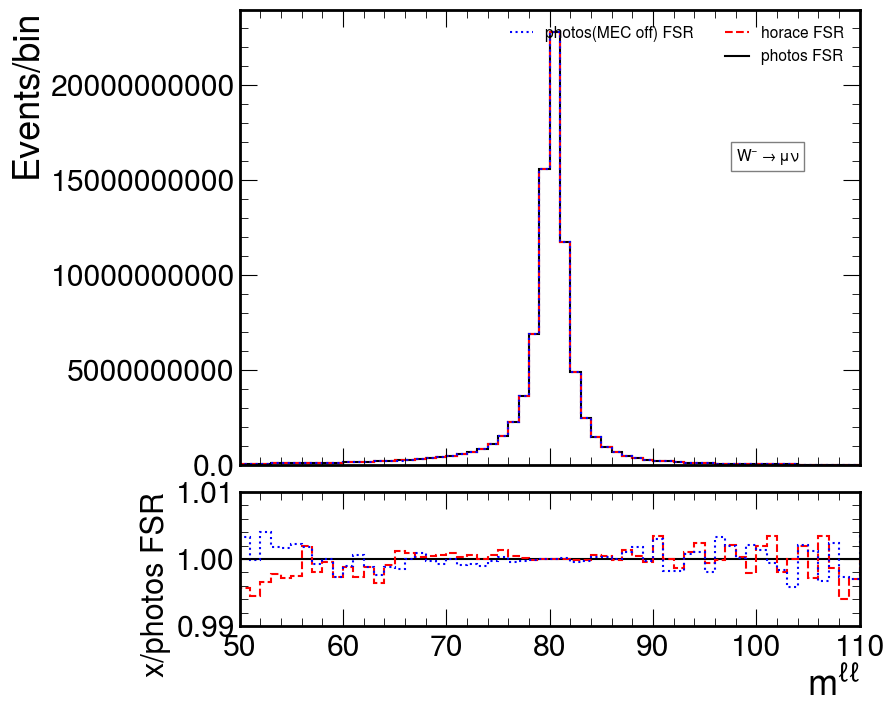

In [174]:
plot_corr("W", "Mll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":0}, xlim=[50,110], rrange=[0.99,1.01])

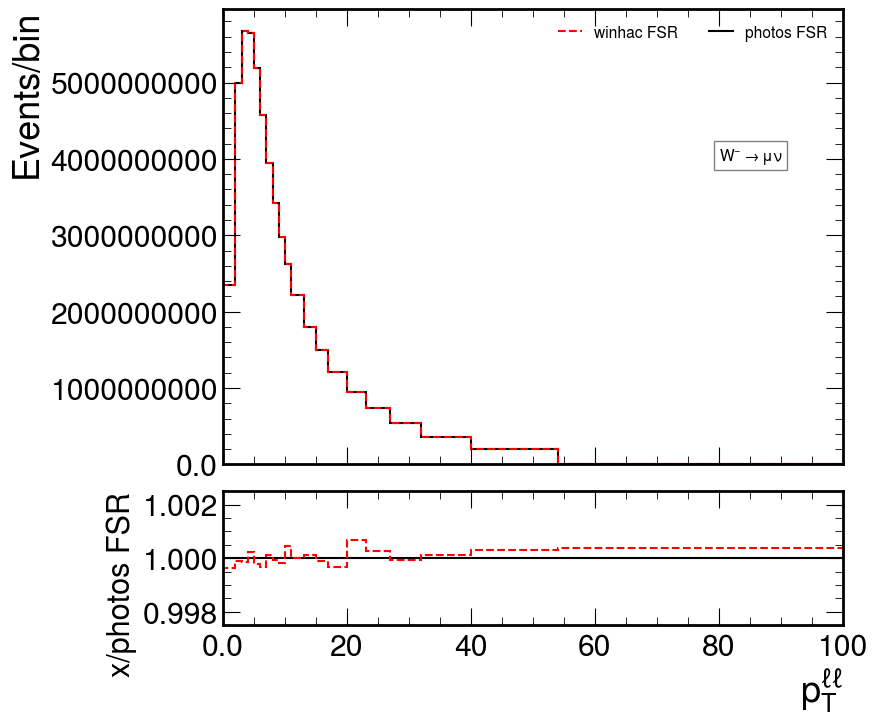

In [163]:
plot_corr("W", "ewPTll", ["winhacloew", ], "winhacloew", selection={"charge":0}, xlim=[0,100])

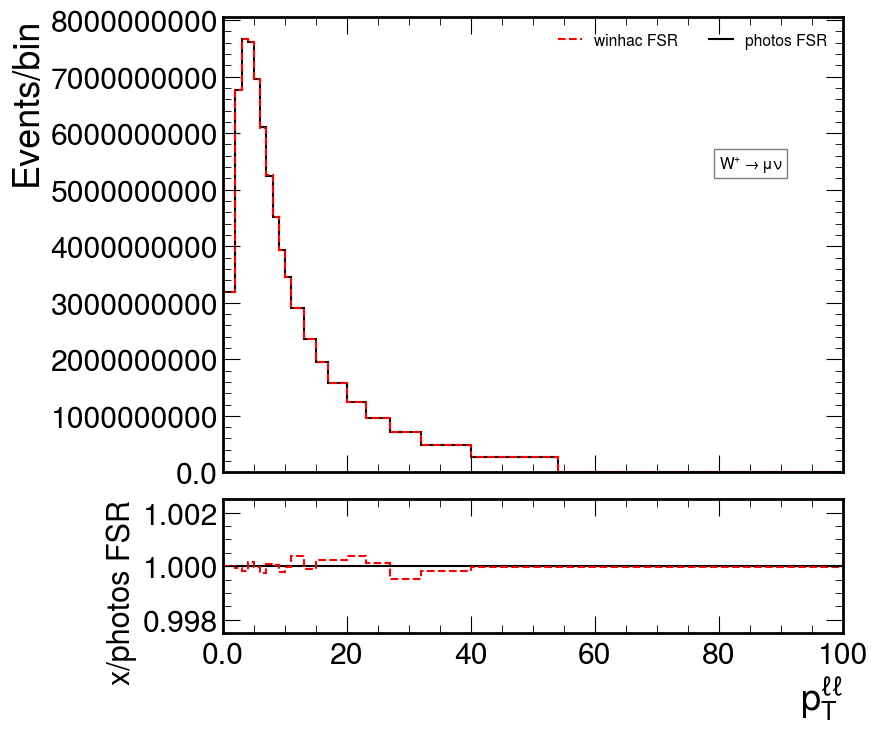

In [164]:
plot_corr("W", "ewPTll", ["winhacloew", ], "winhacloew", selection={"charge":1}, xlim=[0,100])

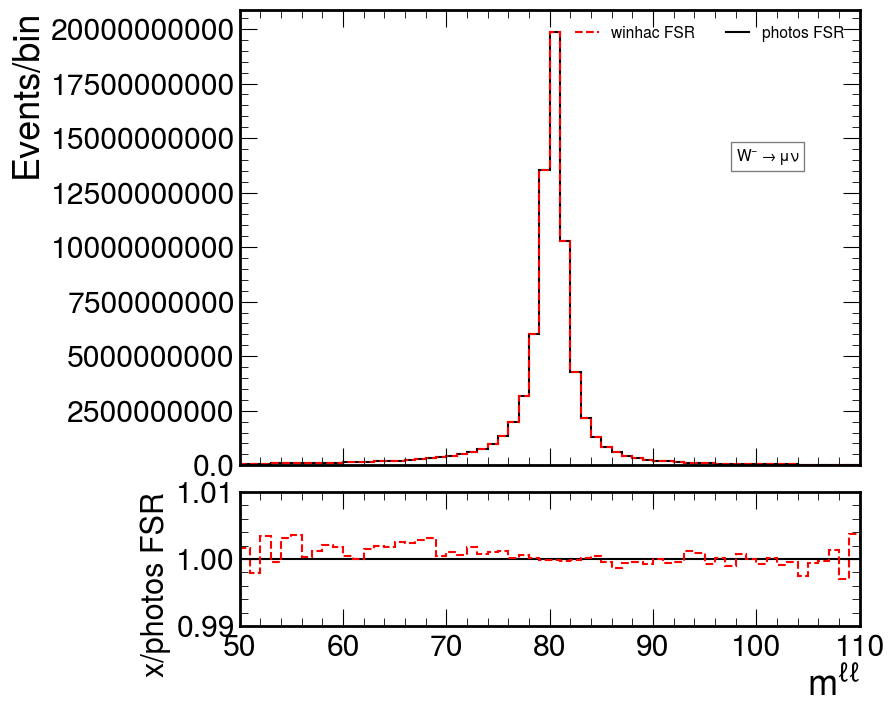

In [175]:
plot_corr("W", "Mll", ["winhacloew"], "winhacloew", selection={"charge":0}, xlim=[50,110], rrange=[0.99,1.01])

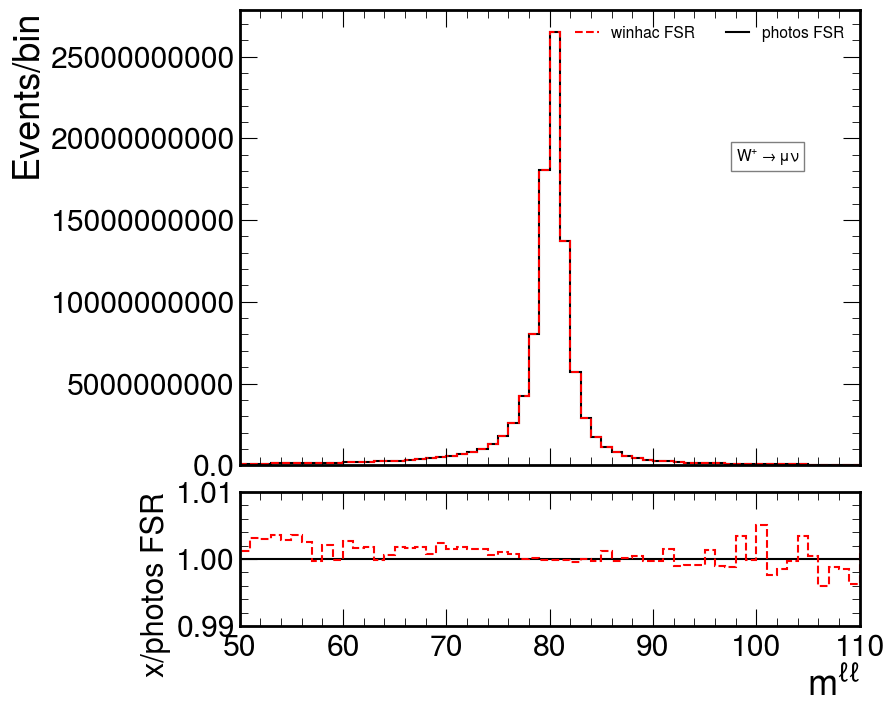

In [176]:
plot_corr("W", "Mll", ["winhacloew"], "winhacloew", selection={"charge":1}, xlim=[50,110], rrange=[0.99,1.01])

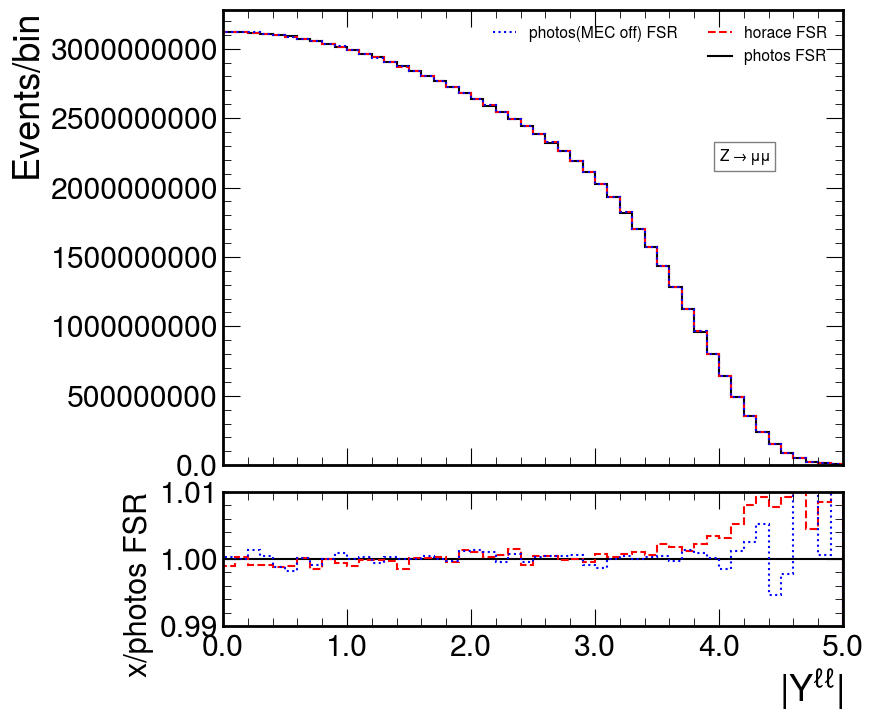

In [180]:
plot_corr("Z", "Yll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", xlim=[0,5], rrange=[0.99, 1.01])

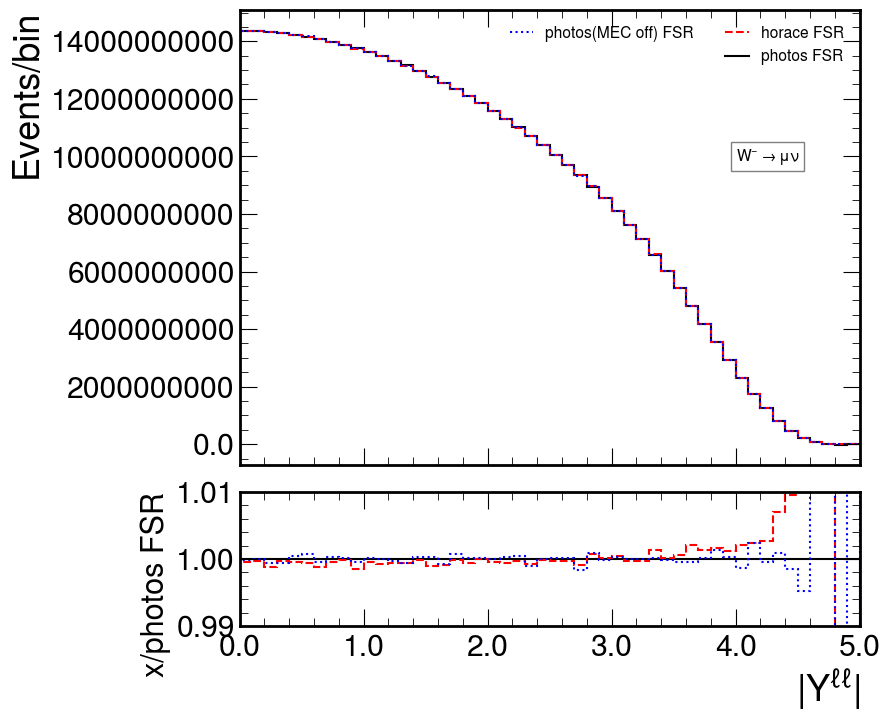

In [181]:
plot_corr("W", "Yll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":0}, xlim=[0,5], rrange=[0.99, 1.01])

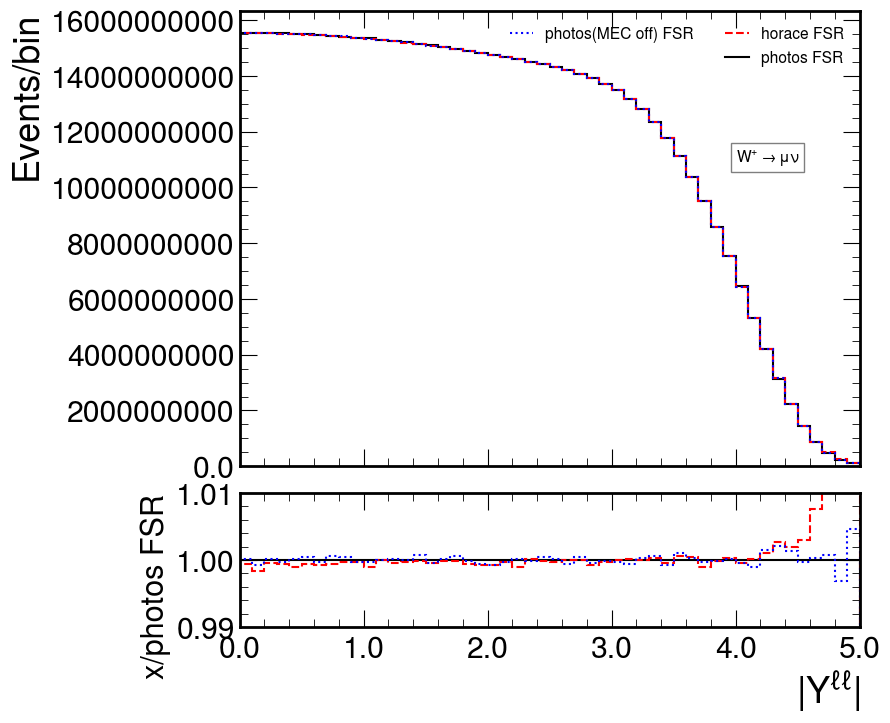

In [182]:
plot_corr("W", "Yll", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", selection={"charge":1}, xlim=[0,5], rrange=[0.99, 1.01])

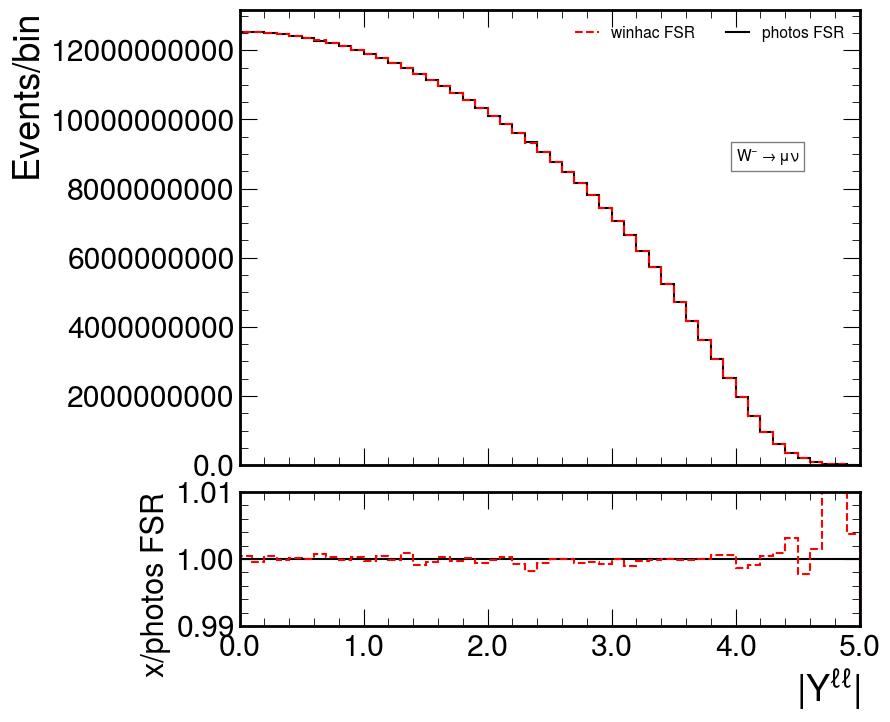

In [183]:
plot_corr("W", "Yll", ["winhacloew"], "winhacloew", selection={"charge":0}, xlim=[0,5], rrange=[0.99,1.01])

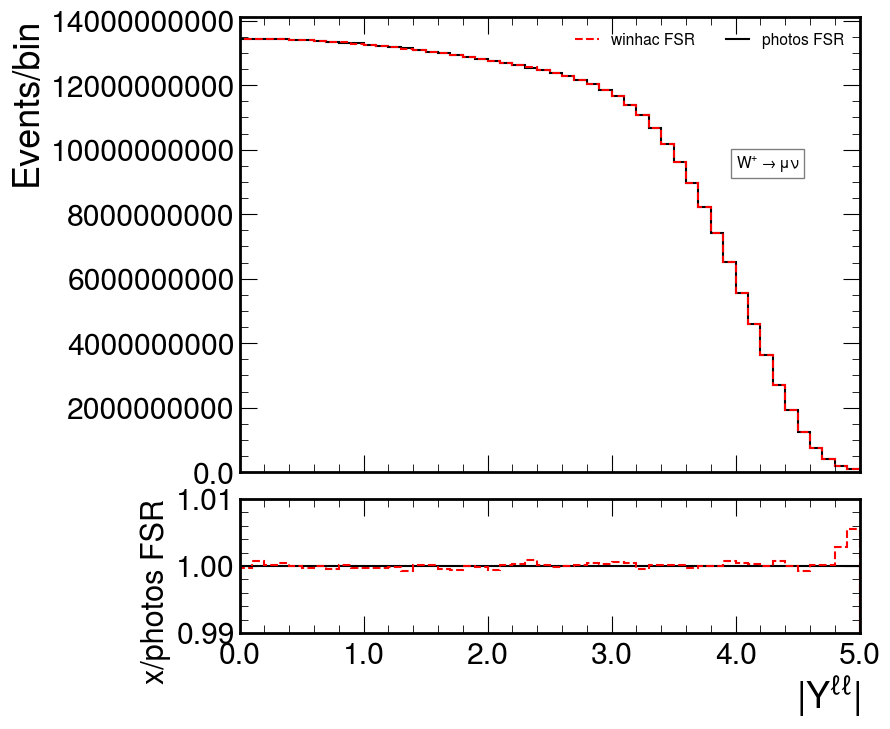

In [184]:
plot_corr("W", "Yll", ["winhacloew"], "winhacloew", selection={"charge":1}, xlim=[0,5], rrange=[0.99,1.01])

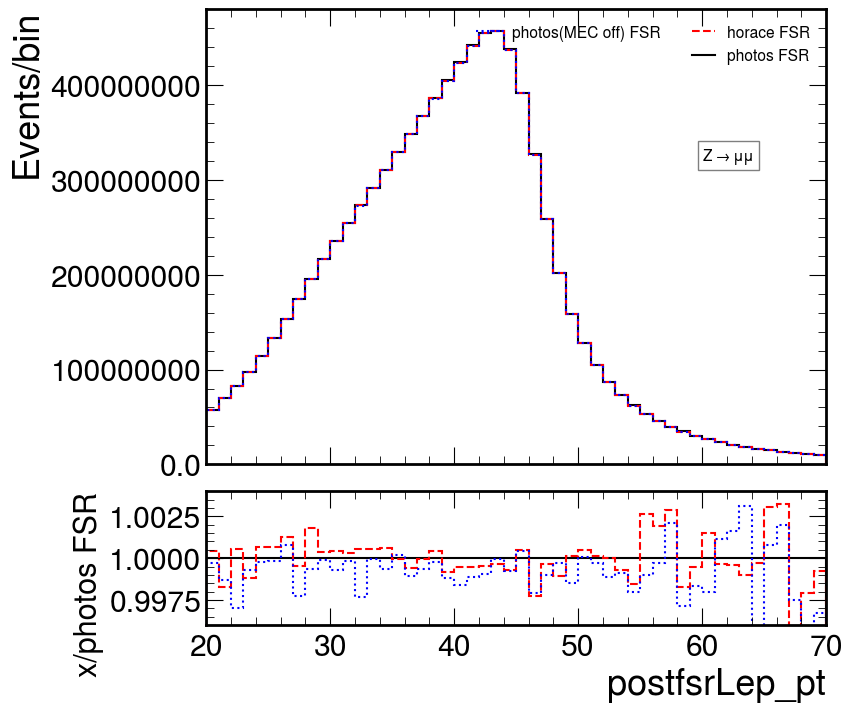

In [16]:
plot_corr("Z", "postfsrLep_pt", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", xlim=[20,70])

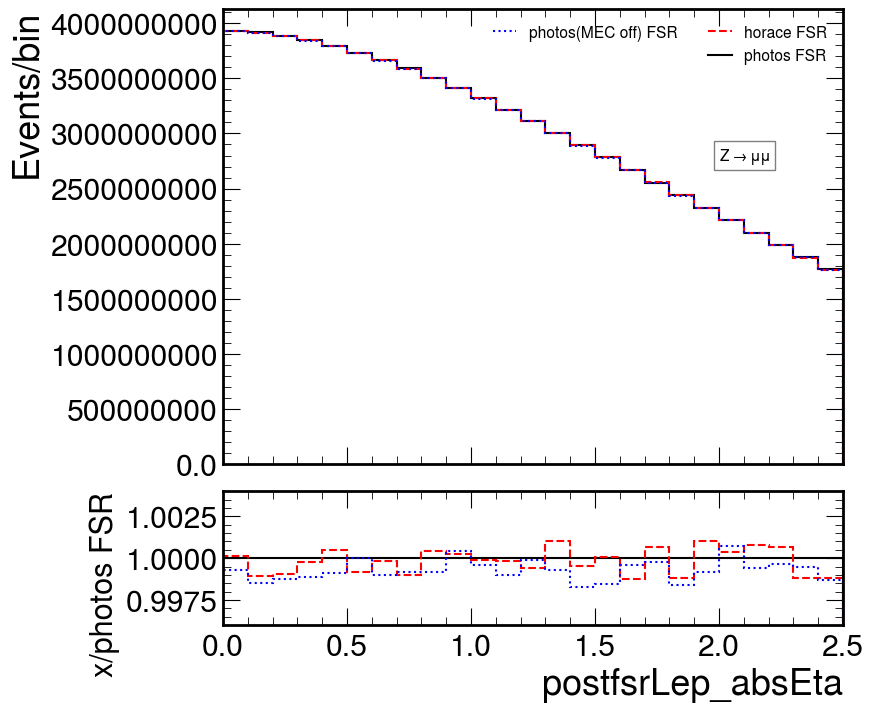

In [17]:
plot_corr("Z", "postfsrLep_absEta", ["horaceqedew", "horacelophotosmecoffew"], "horaceqedew", xlim=[0,2.5])

TypeError: '<' not supported between instances of 'list' and 'int'

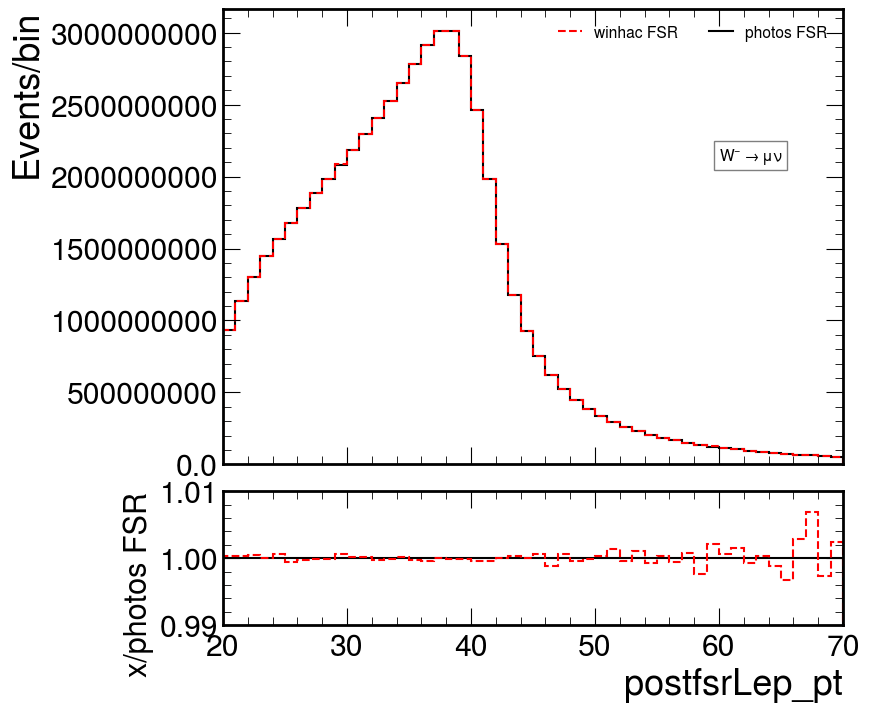

In [19]:
plot_corr("W", "postfsrLep_pt", ["winhacloew"], "winhacloew", selection={"charge":0}, xlim=[20,70], rrange=[0.99,1.01])

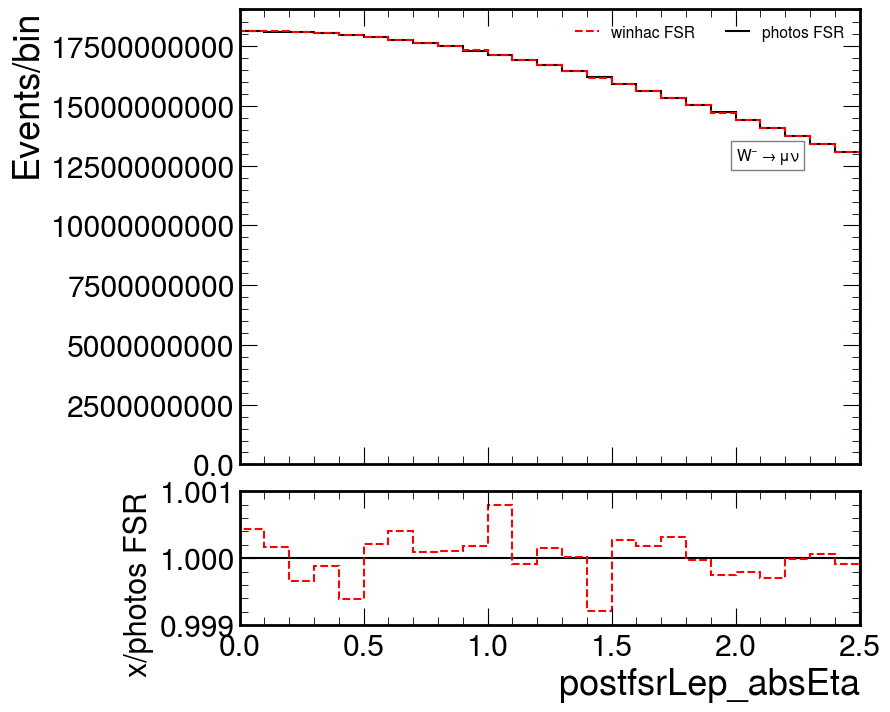

In [21]:
plot_corr("W", "postfsrLep_absEta", ["winhacloew"], "winhacloew", selection={"charge":0}, xlim=[0,2.5], rrange=[0.999,1.001])